# Edmunds Forum Scraping and Analysis

### Section 1

This section scrapes 4500 comments from the following Edmunds forum: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/

This forum contains general comments about entry level luxury performance sedans.

After scraping this data is stored in a CSV file with each row containing the date of the comment, username of the commenter, and the comment itself.


In [ ]:
!pip install selenium
!apt-get -q update
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [60]:
import pandas as pd

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [ ]:
comments = pd.DataFrame(columns = ['Date','user_id','comments'])
page = 1
while True:
    print(len(comments))
    if(len(comments.index) >= 4500):
    break
    driver.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p" + str(page))
    page+=1
    ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
    comment_ids = []
    for i in ids:
        comment_ids.append(i.get_attribute('id'))
    for x in comment_ids:
        #Extract dates from for each user on a page
        user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
        date = user_date.get_attribute('title')

        #Extract user ids from each user on a page
        userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
        userid = userid_element.text

        #Extract Message for each user on a page
        user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
        comment = user_message.text

        #Adding date, userid and comment for each user in a dataframe    
        comments.loc[len(comments)] = [date,userid,comment]

In [62]:
comments.to_csv("edmunds_comments.csv", index=False)

### Section 2
This section reads in the CSV file containing 4500 comments and cleans/preprocesses it. It replaces all mentions of models with their respective brands. It then identifies the top 10 brands by frequency (only counting a mention once per post even if the brand is mentioned multiple times). It then calculates lift ratios for associations between the brands and displays a lift matrix. The lift values are then manipulated to make the effects more noticeable for the next step. Finally, it creates a multi-dimensional scaling map to visualize the similarities between the brands.

In [63]:
import pandas as pd
import numpy as np
#following file comes from section 1
commentsdf = pd.read_csv("edmunds_comments.csv").dropna()
commentsdf[:5]

,Date,user_id,comments
0,"March 24, 2002 10:54PM",merc1,I personally think that with a few tweaks the ...
1,"March 25, 2002 12:06AM",fredvh,I am debating a new purchase and these two are...
2,"March 25, 2002 10:02AM",blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,"March 25, 2002 4:04PM",hungrywhale,And no manual tranny. That may not matter to y...
4,"March 25, 2002 5:44PM",riez,One beauty of BMW 3 Series is that there are s...


In [64]:
#make everything lowercase
commentsdf['comments'] = commentsdf['comments'].str.lower()
model_brand = pd.read_csv("car_models_and_brands.csv", header=None, names=["brand", "model"])
brands = list(model_brand["brand"].values)
models = list(model_brand["model"].values)
def replace_model_with_brand(c):
    for i in range(len(models)):
        #adding spaces around model to avoid replacing parts of other words
        if str(" " + models[i] + " ") in c:
            #print("REPLACING ", models[i], " WITH ", brands[i])
            c = c.replace(models[i], brands[i])
    return c
commentsdf['comments'] = commentsdf['comments'].map(replace_model_with_brand)

In [ ]:
#remove some words from brands list that aren't really brands
[brands.remove(word) for word in ["car", "problem", "sedan"] if word in brands]
brands_unique = set(brands)
brand_counts = {}
#initialize empty dict
for brand in brands_unique:
    brand_counts[brand] = 0

def get_brand_counts(c):
    for brand in brands_unique:
        if brand in c:
            brand_counts[brand]+=1
commentsdf['comments'].map(get_brand_counts)

In [66]:
brand_counts = pd.Series(brand_counts).sort_values(ascending=False)
brand_counts[:10]

bmw         1257
acura        522
audi         388
infiniti     375
honda        349
nissan       265
seat         259
toyota       221
ford         211
subaru       187
dtype: int64

In [67]:
def get_lift(b1, b2):
    freq_b1 = brand_counts[b1]
    freq_b2 = brand_counts[b2]
    freq_both = 0
    for comment in list(commentsdf['comments'].values):
        if b1 in comment and b2 in comment:
            freq_both += 1
    #calculate lift
    return (len(commentsdf)*freq_both)/(freq_b1*freq_b2)

brand_lifts = pd.DataFrame(index=brand_counts[:10].index, columns=brand_counts[:10].index)
for brand1 in brand_counts[:10].index:
    for brand2 in brand_counts[:10].index:
        if brand1==brand2:
            continue
        else:
            brand_lifts.loc[brand1, brand2] = get_lift(brand1, brand2)
brand_lifts

,bmw,acura,audi,infiniti,honda,nissan,seat,toyota,ford,subaru
bmw,NaN,1.60017,1.82161,1.98946,1.21715,1.23926,1.66766,1.35677,1.43799,1.14533
acura,1.60017,NaN,2.08248,3.00279,2.7339,2.04353,1.32753,1.63359,1.71101,1.7927
audi,1.82161,2.08248,NaN,2.4054,1.22603,1.30918,2.14322,1.20354,2.02789,1.66973
infiniti,1.98946,3.00279,2.4054,NaN,1.64566,3.16065,1.57074,1.40769,1.75794,1.7916
honda,1.21715,2.7339,1.22603,1.64566,NaN,4.31792,1.38992,4.7122,2.13263,1.16879
nissan,1.23926,2.04353,1.30918,3.16065,4.31792,NaN,1.43825,4.52033,1.68518,1.81092
seat,1.66766,1.32753,2.14322,1.57074,1.38992,1.43825,NaN,1.88137,1.80633,1.11172
toyota,1.35677,1.63359,1.20354,1.40769,4.7122,4.52033,1.88137,NaN,2.40559,1.52002
ford,1.43799,1.71101,2.02789,1.75794,2.13263,1.68518,1.80633,2.40559,NaN,1.47834
subaru,1.14533,1.7927,1.66973,1.7916,1.16879,1.81092,1.11172,1.52002,1.47834,NaN


In [68]:
#make lifts a little more exaggerated so mds map will be easier to visualize
brand_lifts = brand_lifts.pow(1.5)
brand_lifts

,bmw,acura,audi,infiniti,honda,nissan,seat,toyota,ford,subaru
bmw,NaN,2.02418,2.45856,2.8061,1.34281,1.37957,2.15357,1.58038,1.72439,1.22573
acura,2.02418,NaN,3.00519,5.20341,4.52038,2.92126,1.52957,2.08792,2.2381,2.40029
audi,2.45856,3.00519,NaN,3.73062,1.35753,1.49796,3.13761,1.32035,2.88779,2.15759
infiniti,2.8061,5.20341,3.73062,NaN,2.11111,5.61908,1.96859,1.67016,2.33081,2.39807
honda,1.34281,4.52038,1.35753,2.11111,NaN,8.97247,1.63864,10.229,3.1144,1.26359
nissan,1.37957,2.92126,1.49796,5.61908,8.97247,NaN,1.72484,9.6107,2.18761,2.43696
seat,2.15357,1.52957,3.13761,1.96859,1.63864,1.72484,NaN,2.58055,2.4277,1.17218
toyota,1.58038,2.08792,1.32035,1.67016,10.229,9.6107,2.58055,NaN,3.73106,1.87402
ford,1.72439,2.2381,2.88779,2.33081,3.1144,2.18761,2.4277,3.73106,NaN,1.79748
subaru,1.22573,2.40029,2.15759,2.39807,1.26359,2.43696,1.17218,1.87402,1.79748,NaN


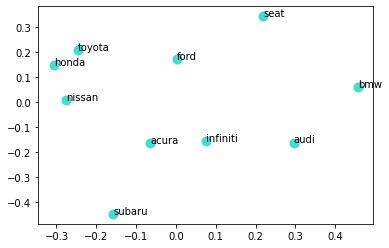

In [69]:
#convert similarity (lifts) to dissimilarity
brand_lifts = 1/brand_lifts
#replace the diagonal with 0s
for i in range(10):
    brand_lifts.iloc[i,i] = 0

#plot MDS map
from sklearn import manifold
from matplotlib import pyplot as plt
mds = manifold.MDS(n_components=2, max_iter=3000,dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(brand_lifts)
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=100, lw=0, label='MDS')
for i, label in enumerate(brand_lifts.index.values):
    plt.annotate(label, (pos[:,0][i], pos[:,1][i]))
plt.show()

### Section 3
This section summarizes insights that we can offer brand managers from the analysis in Task A. Specifically, we choose Toyota, Honda, and Nissan to focus on.

From the lift table, we found that people who mentioned Honda are likely to also mention Toyota or people who mention Toyota are likely to mention Honda at the same time. In other words, these brands often appear in the same comment. Others, such as Honda and Nissan, Toyota and Nissan, have relatively high lift values as well.

Interestingly, these three brands are all major Japanese brands, so they are often compared together by consumers. In the plot, we can also see that these brands are close to each other, which means customers buying one brand are likely to consider switching between these three brands.

Why do people like Japanese cars? The reason is probably because of practicality and efficiency rule. Japanese automobile manufacturer will strictly control every process of producing a car, and the quality of the parts they make is high. In addition, they have plenty of fun family minivan and SUV options to choose from.

I would suggest brand managers compare these brands together, keep the common features, and improve the features of other brands that their own brands do not have. The marketing department can also investigate what consumers like among these brands and advertise on these characteristics. Moreover, if you are a Toyota company, users of Nissan and Honda may be your potential customers.

### Section 4
This section finds the 5 most frequently mentioned attributes of cars. It does this by word tokenizing the comments, removing punctuation and stopwords, and then finding frequency. It only counts each word once per comment even if it appears multiple times. The list is then filtered to find the 5 most frequently mentioned attributes.

We then find the lift ratios between the top 5 attributes and the top 5 brands (brands identified from task A).

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
word_freq = {}
def get_word_freq(c):
    #take set because we only want to count a word once per comment
    tokens = set(word_tokenize(c))
    for token in tokens:
    #disregard if it is punctuation or stop word
    if (not token.isalpha()) or (token in stop_words):
        continue
    if token not in word_freq:
        word_freq[token] = 1
    else:
        word_freq[token] += 1
    return None
commentsdf['comments'].map(get_word_freq)
freq_df = pd.Series(word_freq)
freq_df = freq_df.sort_values(ascending=False)

In [71]:
freq_df[:50]

car            2202
bmw            1215
like           1145
one            1033
would          1015
tl              947
get             905
think           871
better          663
much            661
even            630
drive           627
performance     603
new             596
people          588
good            587
know            580
sedan           567
really          561
best            525
well            525
also            515
acura           493
still           487
want            484
say             482
could           467
time            462
driving         460
way             448
see             445
make            443
go              425
luxury          402
engine          400
buy             398
series          381
price           375
great           373
going           369
right           367
take            363
many            359
less            356
got             355
infiniti        350
power           350
look            345
handling        338
audi            338


This list has a lot of words that are not really attributes but moreso filler words. Scanning through the list, it looks like the first 5 attributes mentioned are **performance, luxury, engine, price** and **handling**.

In [72]:
top5_attr = ["performance", "luxury", "engine", "price", "handling"]

In [73]:
def get_brand_attr_lift(b, a):
    freq_b = brand_counts[b]
    freq_a = freq_df[a]
    freq_both = 0
    for comment in list(commentsdf['comments'].values):
        if b in comment and a in comment:
            freq_both += 1
  #calculate lift
  return (len(commentsdf)*freq_both)/(freq_b*freq_a)

brand_attr_lifts = pd.DataFrame(data = 0, index = brand_counts[:5].index, columns=top5_attr)
for brand in brand_counts[:5].index:
    for attr in top5_attr:
        brand_attr_lifts.loc[brand, attr] = get_brand_attr_lift(brand, attr)
brand_attr_lifts

,performance,luxury,engine,price,handling
bmw,1.580574,1.491777,1.838349,2.084652,1.795366
acura,1.596564,2.159638,1.977031,1.948378,1.754761
audi,1.457540,1.495897,2.312887,2.497918,1.642286
infiniti,1.607284,1.785871,1.824713,2.042084,1.522217
honda,1.449847,1.982879,2.024936,2.297070,1.559545


### Section 5
This section summarizes the advice we would give to a product manager and marketing manager of these brands based on the analysis from the previous task.

**BMW**\
*Product Manager* - The main thing a product manager should focus on is increaasing the perceived luxury of BMW's. It seems as though BMW should have a high association with luxury however it is its lowest brand attribute lift of the top five.\
*Marketing/Advertising Manager* -The marketing manager should put in an effort to emphasize the engine of the BMW as well as the price. These have the two highest lift values and is what many associate with BMW.\
**Acura**\
*Product Manager* - The product manager should try to increase the percieved performance of Acura's, as they have a low lift value.\
*Marketing/Advertising Manager* - Emphasizing the luxury of Acuras would work well as it has a very high lift value and is the highest of these five brands.\
**Audi**\
*Product Manager* - The product manager needs to focus on improving the performance and luxury aspects of their Audis.\
*Marketing/Advertising Manager* - The marketing manager should focus on advertising both the engine of the Audi as well as the price.\
**Infiniti**\
*Product Manager* - The handling aspect of Infiniti cars needs to be improved as it has the lowest lift of all five brands.\
*Marketing/Advertising Manager* - The marketing manager should focus on ephasizing the price of the cars.\
**Honda**\
*Product Manager* - The Honda product manager really needs to focus on improving the performance and handling of their cars.\
*Marketing/Advertising Manager* - The marketing manager can focus on luxury, engine and/or price, as they all have high lift values.

### Section 6
In this section, we explore which brand is most *aspirational* in terms of people wanting to buy or own and then briefly summarize the business implications for the brand.

In [ ]:
#aspirational.csv contains the following phrases
#which we replace with the word 'aspirational'
#"want to buy","wish to buy","hope to buy","want to own","wish to own","dream car","hope to own","desire to buy","desire to own","want to purchase","wish to purchas","hope to purchase","desire to purchase","wanting","hoping","wishing","dreaming"
asp_list = pd.read_csv("aspirational.csv", header=None, names=["aspirational", "terms"])
asp_terms = list(asp_list["terms"].values)
def replace_terms_with_asp(c):
    for i in range(len(asp_terms)):
    #adding spaces around term to avoid replacing parts of other words
    if str(" " + asp_terms[i] + " ") in c:
        c = c.replace(asp_terms[i], "aspirational")
    return c
commentsdf['comments'] = commentsdf['comments'].map(replace_terms_with_asp)

#get brand counts again but also get "aspirational" counts
brands_and_asp = list(brands_unique) + ['aspirational']
brand_asp_counts = {}
#initialize empty dict
for brand_asp in brands_and_asp:
    brand_asp_counts[brand_asp] = 0
def get_brand_asp_counts(c):
    for brand_asp in brands_and_asp:
        if brand_asp in c:
            brand_asp_counts[brand_asp]+=1
commentsdf['comments'].map(get_brand_asp_counts)

In [75]:
brand_asp_counts = pd.Series(brand_asp_counts).sort_values(ascending=False)
brands_asp_list = brand_asp_counts[:10].index.tolist() + ['aspirational']
brands_asp_freq = brand_asp_counts[brands_asp_list]
brands_asp_freq

bmw             1257
acura            522
audi             388
infiniti         375
honda            349
nissan           265
seat             259
toyota           221
ford             211
subaru           187
aspirational      39
dtype: int64

In [76]:
# not changed
def get_lift(b1, b2):
    freq_b1 = brand_asp_counts[b1]
    freq_b2 = brand_asp_counts[b2]
    freq_both = 0
    for comment in list(commentsdf['comments'].values):
        if b1 in comment and b2 in comment:
            freq_both += 1
    #calculate lift
    return (len(commentsdf)*freq_both)/(freq_b1*freq_b2)

# changed index and columns!!!!
brand_lifts = pd.DataFrame(index=brands_asp_freq.index, columns=brands_asp_freq.index, data=1)
for brand1 in brands_asp_freq.index:
    for brand2 in brands_asp_freq.index:
        if brand1==brand2:
            continue
        else:
            brand_lifts.loc[brand1, brand2] = get_lift(brand1, brand2)
# check aspriations
brand_lifts.iloc[0:10,[10]].sort_values(by='aspirational', ascending=False)

,aspirational
ford,3.271600
infiniti,3.068034
seat,2.221067
bmw,1.647512
acura,1.322429
toyota,1.041188
honda,0.988980
audi,0.889572
subaru,0.615247
nissan,0.434156


Analyzing the top 10 most frequently discussed brands on the forum for their aspirationality we got unintuitive and interesting results. We related aspirationality to several diferent unigrams, bigrams, and trigrams to capture the broad sentiment of aspiration. The terms we used were: *want to buy, wish to buy, hope to buy, want to own, wish to own, dream car, hope to own, desire to buy, desire to own, want to purchase, wish to purchase, hope to purchase, desire to purchase, wanting, hoping, wishing, and dreaming.* 

We felt these words capture much of the aspirational sentiment. We replaced the terms with 'aspirational' and conducted a lift analysis accross the top 10 most frequent brands. This resulted in 39 incidences of use in a post and a lift range of 3.2716 to 0.434156. Of the results, Ford was the most aspirational brand at 3.2716, with infiniti not far behind at 3.068034. 

This is interesting because Ford is typically considered a working class brand and the discussion was pulled form a luxury performance sedan forum. One potential cause is that Ford was actually an unaspirational brand and people 'want to buy' or aspire to own another vechicle but, since people reference Ford in the post, it contributes to the lift. Another thing to note is that the support for these lifts are all quite low, which could be further skewing results.

However, assuming the analysis correct, this has strong marketing, sales, and design implications for Ford. The brand can use aspirational phrases and slogans to connect with the consumer in its advertisment. It could also conduct an aspiration deal which applies to savings if switching cars. Or it could introduce a sport fusion to pick up on the clean looks and performance associated with luxury performance sedans. Regardless of the specific implication, this insight can be very useful to Ford.